In [5]:
import os
import random
import numpy as np
import pandas as pd
import sys

# 1.轉資料格式

> 參考 : https://d246810g2000.medium.com/%E5%A6%82%E4%BD%95%E4%BD%BF%E7%94%A8%E8%87%AA%E5%B7%B1%E7%9A%84%E8%B3%87%E6%96%99%E9%9B%86%E8%A8%93%E7%B7%B4-yolox-c02548734a48

> doument : https://yolox.readthedocs.io/_/downloads/en/latest/pdf/

- (1) 將標記好的資料放在 YOLOX/datasets/data 裡，裡面要包含訓練的影像 (jpg) 和對應的標註 (xml)，
- (2) 接著我們使用 train_val_data_split_coco.py 來生成對應的資料夾結構和切分資料集，這邊設置的比例為 9:1

```
data_path = 'data/'
output_dir = 'FM_model_3class/'
jsons_path = os.path.join(output_dir, 'annotations/')
train_imgs_path = os.path.join(output_dir, 'train2017/')
val_imgs_path = os.path.join(output_dir, 'val2017/')
```



In [14]:
! python datasets/train_val_data_split_coco.py

# 2. model train

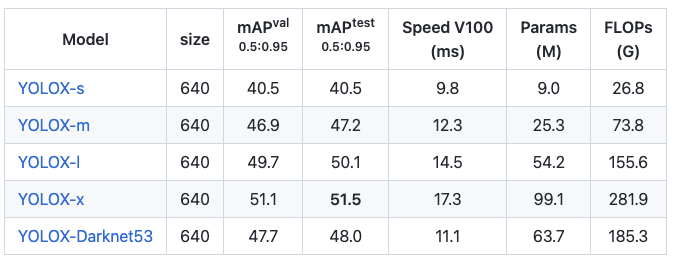

## 修改訓練參數:
## (1) 修改yolox_s.py:
#### 在 YOLOX/exps/example/custom/yolox_s.py 中，修改資料夾路徑 self.data_dir 和類別數量 self.num_classes
```
# Define yourself dataset path
self.data_dir = "datasets/FM_model_3class"
self.train_ann = "instances_train2017.json"
self.val_ann = "instances_val2017.json"
self.num_classes = 3
self.max_epoch = 300
self.data_num_workers = 4
self.eval_interval = 1
```
## (2) 修改coco_classes.py:
#### 在 YOLOX/yolox/data/datasets/coco_classes.py 中的類別改成自己對應的類別
```
COCO_CLASSES = (
    "OK_Area",
    "NG_Area",
	"NG_Other"
)
```


## 訓練指令

```
-d: number of gpu devices
-b: total batch size, the recommended number for -b is num-gpu * 8
–fp16: mixed precision training
–cache: caching imgs into RAM to accelarate training, which need large system RAM.
-c : yolox_s.pth
```

## 不須調整leaning ratio
* 依照 batch size調整 leaning ratio  -> 可調低batch size leaning ratio

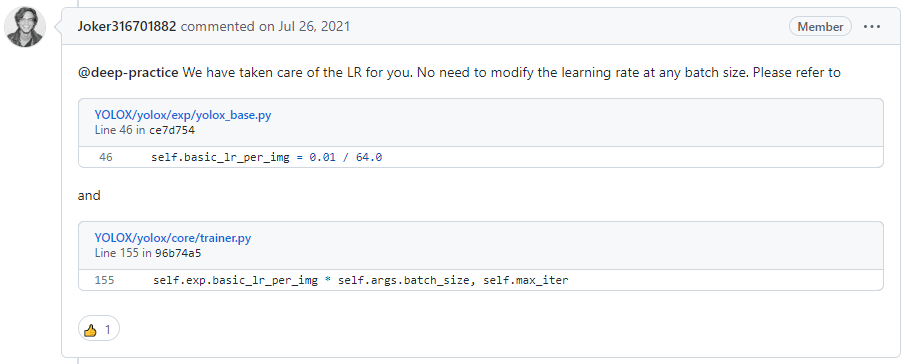

In [15]:
os.listdir('exps/example/custom/')

['__pycache__', 'yolox_s.py', 'nano.py', '.ipynb_checkpoints', 'yolox_m.py']

In [ ]:
! python tools/train.py \
-f exps/example/custom/yolox_m.py \
-d 0 \
-b 4 \
--fp16 \
-o \
# -c YOLOX_outputs/yolox_m_3class/best_ckpt.pth

# 3. model test

## 測試指令

```
-f 後面放參數設定的檔案，這邊使用官方的預設參數 exps/default/yolox_s.py
-c 後面放預測時使用的 weight 檔，這邊使用官方的預訓練模型 yolox_s.pth
--path 後面放你要預測的圖片路徑，也可以放想要預測的資料夾路徑，這邊使用官方提供的照片 assets/dog.jpg
--conf 後面放 confidence 的 threshold，這邊使用 0.25
--nms 後面放非極大值抑制 (Non-Maximum Suppression) 的 threshold，這邊使用 0.45
--tsize 後面放你要將影像 resize 成多大丟進模型裡預測，這邊使用 640
--save_result 如果要將預測結果存下來可以加這個
--device 要用什麼 device 預測，可選 cpu 或 gpu，這邊使用 gpu
```

In [18]:
!python tools/demo.py image -f exps/example/custom/yolox_m.py -c YOLOX_outputs/yolox_m_diesaw/best_ckpt.pth \
--path datasets/diesaw_model-test/OK_Chipping/ \
--conf 0.25 \
--nms 0.5 \
--tsize 640 \
--save_result \
--device [0]

2022-11-17 09:03:33.124 | INFO     | __main__:main:259 - Args: Namespace(camid=0, ckpt='YOLOX_outputs/yolox_m_diesaw/best_ckpt.pth', conf=0.25, demo='image', device='[0]', exp_file='exps/example/custom/yolox_m.py', experiment_name='yolox_m', fp16=False, fuse=False, legacy=False, name=None, nms=0.5, path='datasets/diesaw_model-test/OK_Chipping/', save_result=True, trt=False, tsize=640)
2022-11-17 09:03:33.497 | INFO     | __main__:main:269 - Model Summary: Params: 25.28M, Gflops: 73.50
2022-11-17 09:03:33.501 | INFO     | __main__:main:282 - loading checkpoint
2022-11-17 09:03:33.769 | INFO     | __main__:main:286 - loaded checkpoint done.
2022-11-17 09:03:34.048 | INFO     | __main__:inference:165 - Infer time: 0.2662s
2022-11-17 09:03:34.051 | INFO     | __main__:image_demo:202 - Saving detection result in ./YOLOX_outputs/yolox_m/vis_res/2022_11_17_09_03_33/DM81F2-RL0DMFZ-012-(+0056+0000)-006.JPG
2022-11-17 09:03:34.305 | INFO     | __main__:inference:165 - Infer time: 0.2383s
2022-11